In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
%matplotlib inline
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [2]:
import zipfile

def path_extractor(zipPATH,zip_file,trgt_dir):
  if 'chest_xray' not in os.listdir('.'):
    with zipfile.ZipFile(zipPATH+zip_file,"r") as z:
            print(f"Extracting content from {zip_file} ......")
            z.extractall()
            print(f"Extracted to {os.getcwd()}")
  paths = [] 
  cls_labels = []
  print(f"Reading image paths in chest_xray/{trgt_dir} directory")
  folder = "."+os.path.sep+'chest_xray'+os.path.sep+trgt_dir
  print(f'Available classes {os.listdir(folder)}')
  for root, dirs, files in os.walk(folder):
      for file in files:
        if file.endswith(".jpeg"):
          f_path = os.path.join(root, file)
          f_path=f_path.replace('\\','/');
          label = f_path.split('/')[-2]
          cls_labels.append(label)
          paths.append(f_path)
  print("DONE")
  return paths,cls_labels

In [3]:
# Location of zipfile containing dataset
PATH = "C:/Users/SAI CHARAN/Downloads/"
zip_file = "pnuemonia.zip"

trainImg_paths, y_train = path_extractor(PATH,zip_file,trgt_dir="train")
testImg_paths, y_test = path_extractor(PATH,zip_file,trgt_dir="test")

Extracting content from pnuemonia.zip ......
Extracted to d:\studies\4-2\MajorProject
Reading image paths in chest_xray/train directory
Available classes ['NORMAL', 'PNEUMONIA']
DONE
Reading image paths in chest_xray/test directory
Available classes ['NORMAL', 'PNEUMONIA']
DONE


In [4]:
import cv2

IMAGE_SIZE = (150,150)

def images_extractor(paths):
  '''
  Reading images from provided list and return pre-processed images.
  '''
  images = []
  for path in paths:
    currImg_BGR = cv2.imread(path)
    b,g,r = cv2.split(currImg_BGR)
    currImg_RGB = cv2.merge([r,g,b])
    currImg = cv2.resize(currImg_RGB,IMAGE_SIZE)
    images.append(currImg)
  return images

In [5]:
X_train = images_extractor(trainImg_paths)
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of train set",X_train.shape)
print("Number of train samples",len(X_train))

Shape of train set (5216, 150, 150, 3)
Number of train samples 5216


In [6]:
X_test = images_extractor(testImg_paths)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of test set",X_test.shape)
print("Number of test samples",len(X_test))

Shape of test set (624, 150, 150, 3)
Number of test samples 624


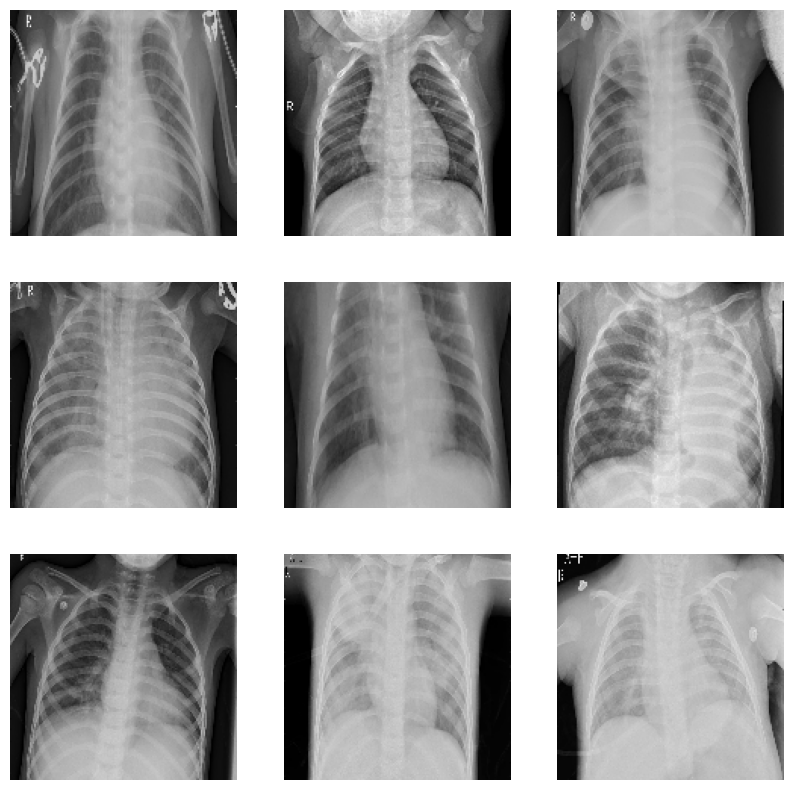

In [7]:
# Visualizing random images from train samples
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(X_train))
  plt.imshow(X_train[random_num][:,:,:])
  plt.grid(False)
  plt.axis('off')

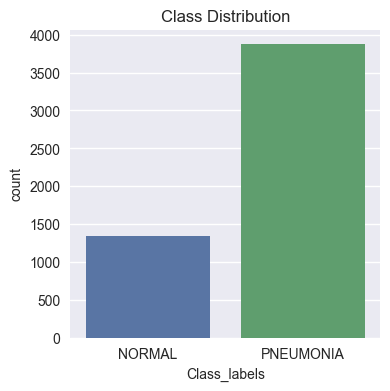

In [8]:
# Checking distribution of classes in train set
y_train_df = pd.DataFrame(y_train,columns=["Class_labels"])
plt.figure(figsize=(4,4))
plt.title("Class Distribution")
sns.countplot(x='Class_labels',data=y_train_df)
plt.show()

In [9]:
# for reproducibility
seed = 100
np.random.seed(seed)

In [10]:
from sklearn.model_selection import train_test_split

valRatio = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio, random_state=seed)

In [12]:
print("Shape of train set",X_train.shape)
print("Shape of validation set",X_val.shape)
print("Shape of test set",X_test.shape)

Shape of train set (4694, 150, 150, 3)
Shape of validation set (522, 150, 150, 3)
Shape of test set (624, 150, 150, 3)


In [13]:
# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [15]:
pd.get_dummies(y_train,drop_first=True).head()

,PNEUMONIA
0,1
1,0
2,1
3,1
4,1


In [16]:
y_train = pd.get_dummies(y_train,drop_first=True).values
y_val = pd.get_dummies(y_val,drop_first=True).values
y_test = pd.get_dummies(y_test,drop_first=True).values
y_train[:5]

array([[1],
       [0],
       [1],
       [1],
       [1]], dtype=uint8)

In [17]:
# Loading Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPool2D
from keras.layers import Conv2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [18]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# Displaying model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [19]:
# Initializing callbacks
path = f"./model.h5"

# Saves the model in-between epochs when there is an improvement in "val_loss"
checkpoint = ModelCheckpoint(path,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)

# Stops training the model when no improvement in "val_loss" is observed after set "patience"
earlystop = EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0, 
                              patience = 4,
                              verbose = 1,
                              restore_best_weights = True)

# Monitors "val_loss" for a set 'patience', then the learning rate is reduced by a factor specified manually.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, verbose=1,
                              factor=0.3, min_lr=0.000001)

callbacks = [checkpoint, earlystop, reduce_lr]

In [20]:
# Training the model for 15 epochs with a batch size of 8
history = model.fit(datagen.flow(X_train,y_train, batch_size = 8), 
                    epochs = 15, validation_data = datagen.flow(X_val, y_val),  
                    callbacks = callbacks)

Epoch 1/15
587/587 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8287
Epoch 1: val_loss improved from inf to 0.49251, saving model to .\model.h5
587/587 [==============================] - 224s 376ms/step - loss: 0.5488 - accuracy: 0.8287 - val_loss: 0.4925 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 2/15
587/587 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8833
Epoch 2: val_loss improved from 0.49251 to 0.26015, saving model to .\model.h5
587/587 [==============================] - 244s 416ms/step - loss: 0.3082 - accuracy: 0.8833 - val_loss: 0.2601 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 3/15
587/587 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.9088
Epoch 3: val_loss did not improve from 0.26015
587/587 [==============================] - 241s 411ms/step - loss: 0.2666 - accuracy: 0.9088 - val_loss: 0.2965 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 4/15
587/587 [==============================] - ETA: 0s - los

In [21]:
# Print validation accuracy for each epoch
val_acc = history.history['val_accuracy']
for epoch, acc in enumerate(val_acc):
    print("Epoch {}: Validation Accuracy = {:.3f}".format(epoch+1, acc))

Epoch 1: Validation Accuracy = 0.854
Epoch 2: Validation Accuracy = 0.920
Epoch 3: Validation Accuracy = 0.900
Epoch 4: Validation Accuracy = 0.893
Epoch 5: Validation Accuracy = 0.950
Epoch 6: Validation Accuracy = 0.738
Epoch 7: Validation Accuracy = 0.925
Epoch 8: Validation Accuracy = 0.944
Epoch 9: Validation Accuracy = 0.944
Epoch 10: Validation Accuracy = 0.943
Epoch 11: Validation Accuracy = 0.948
Epoch 12: Validation Accuracy = 0.962
Epoch 13: Validation Accuracy = 0.943
Epoch 14: Validation Accuracy = 0.944
Epoch 15: Validation Accuracy = 0.946


In [23]:
from keras.models import load_model
# load model
model = load_model('./model.h5')

In [26]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

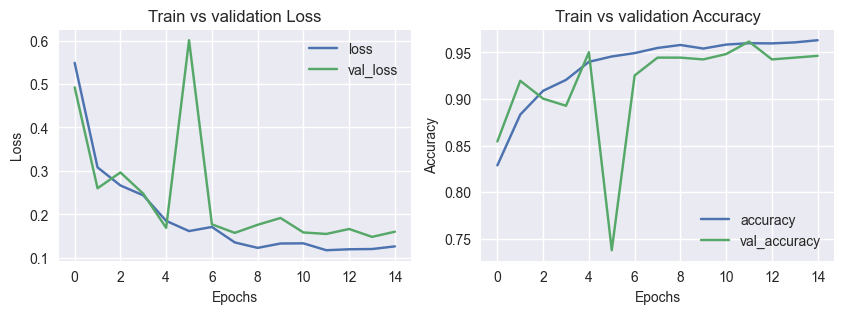

In [27]:
plot_validation_curves(history.history)

In [28]:
# Performing predictions on test data
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print("zero_count=",np.count_nonzero(predictions < 0.5))
print("nonzero_count",np.count_nonzero(predictions >= 0.5))

20/20 [==============================] - 5s 251ms/step
zero_count= 190
nonzero_count 434


In [29]:
from sklearn.metrics import classification_report,confusion_matrix

def plot_summary(predictions):
  '''
  Plots confustion matrix and classification report.
  '''
  # Selecting class based on higher probabilities
  y_pred_classes = predictions
  print("***************** CLASSIFICATION REPORT *****************")
  print(classification_report(y_test,y_pred_classes),"\n\n")
  print("******************* CONFUSION MATRIX *******************")
  plt.figure(figsize=(8,8))
  sns.heatmap(confusion_matrix(y_test,y_pred_classes),linewidths=.5,cmap="YlGnBu",annot=True,cbar=False,fmt='d')
  plt.show()

***************** CLASSIFICATION REPORT *****************
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       234
           1       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624
 


******************* CONFUSION MATRIX *******************


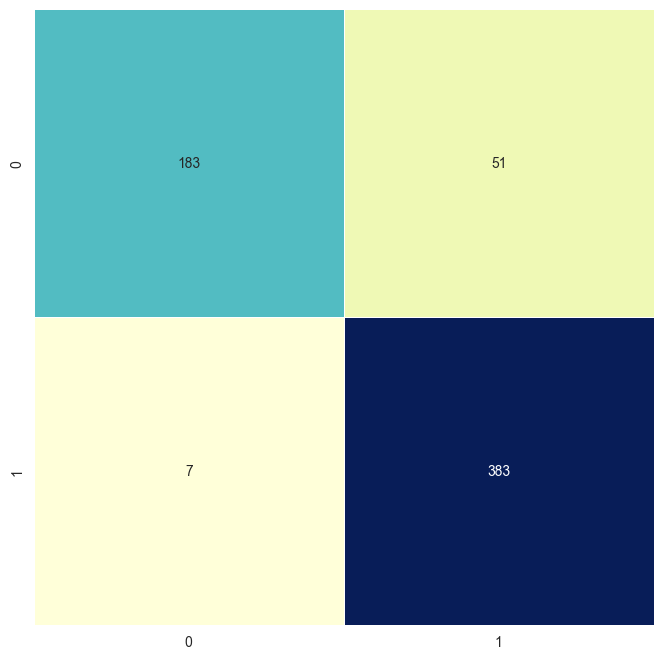

In [30]:
plot_summary(predictions)